#Comp 767 Assignment 1 Question 4
##Jonathan Pearce
##260672004
##jonathan.pearce@mail.mcgill.ca
Link: https://colab.research.google.com/drive/1gm_AW38VksnnHkbXXB5BHfC1EO_yfuam

In [1]:
#Assignment general instructions ask for runtimes in google colab

!pip install ipython-autotime

%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=36999ff2c83855b1fd9a653fe9f2198805a3f7709d9200717f5de9af7cdd219a
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [2]:
#Imports
from random import seed
from random import gauss
from random import random
from math import sqrt
from math import log
from math import exp
import numpy as np

#Plotting tools
import matplotlib
import matplotlib.pyplot as plt

time: 2.66 ms


In [3]:
#Random number seed
seed(14)

#create 10 arms
q_star = [0]*10

for a in range(len(q_star)):
	#sample 10 arm values from a gaussian, mean = 0, variance = 1
	q_star[a] = gauss(0, 1)
	
print(q_star)

[1.219479936120244, 0.9685689584243671, -1.3709773676043076, -1.9388201153191322, -0.10167877335534219, 0.7618966779399574, -0.14656460668317367, -1.4584379721071488, -0.496234435837092, 1.4350099491559036]
time: 6.59 ms


In [4]:
#Experiment Variables
training_iterations = 1000
independent_runs = 10

test_freq = 10
testing_iterations = int(training_iterations/test_freq)

 #optimal arm info
optimalArm = q_star.index(max(q_star))
optimalArm_value = q_star[optimalArm]

time: 5.53 ms


In [5]:
#different random seeds to average runs across
seeds = [1,2,3,4,5,6,7,8,9,10]

time: 2.22 ms


In [6]:
#take current best action and test (pull arm 5 times and average results)
def test(action, iterations=5):
  reward_sum = 0
  for i in range(iterations):
    reward_sum += gauss(q_star[action], 1)
  #test reward
  reward_avg = reward_sum/iterations

  return reward_avg


time: 4.95 ms


In [7]:
#get mean and variance across 10 independent runs
def process_data(frame):
  avg = frame.mean(0)
  var = frame.std(0)
  return avg,var

time: 4.03 ms


In [8]:
#UCB
def UCB(c):

  #data for algorithm analysis and plots
  training_average_reward = np.zeros((independent_runs,training_iterations))
  regret = np.zeros((independent_runs,training_iterations))
  test_reward = np.zeros((independent_runs,testing_iterations))

  #average over 10 independent runs (different seeds)
  for n in range(independent_runs):
    seed(seeds[n])
  
    total_reward = 0
    total_regret = 0

    #UCB variables
    Q = [0]*10
    N = [0]*10

    #run UCB
    for t in range(training_iterations):
      #action at time t
      a_t = 0
      #max score
      ucb_t = 0

      #Find best action
      for a in range(len(N)):
        if N[a] > 0:
          #UCB formula
          score = Q[a] + c*sqrt(log(t)/N[a])
        #If we have not tried an action, assume it is a maximizing action
        #added random noise so we don't go through the actions in the exact same order every time
        else:
          score = 1000 + random()

        #if score is larger than current max then change to action a, and update max score
        if score > ucb_t:
          ucb_t = score
          a_t = a

      #testing
      if (t+1)%10 == 0:
        test_reward[n,int(t/10)] = test(a_t)

      #sample reward
      R_t = gauss(q_star[a_t], 1) 
      #update total reward and total regret
      total_reward += R_t
      total_regret += optimalArm_value - q_star[a_t]
      #calculate avg reward and avg regret at this time step
      avg_reward = total_reward/(t+1)
      avg_regret = total_regret/(t+1)
      #add values to data logs
      training_average_reward[n,t] = avg_reward
      regret[n,t] = optimalArm_value - q_star[a_t]

      #update count
      N[a_t] += 1 
      #update arm estimate
      Q[a_t] = Q[a_t] + (1.0/N[a_t])*(R_t - Q[a_t])

    #print(test_reward)
    train_mean, train_var = process_data(training_average_reward)
    regret_mean, regret_var = process_data(regret)
    test_mean, test_var = process_data(test_reward)

  return train_mean, train_var,regret_mean, regret_var,test_mean, test_var

time: 53.5 ms


In [9]:
def softmax_action(pi):
  #pick action stochastically according to distribution pi 
  rand_num = random()
  for a in range(10):
    rand_num -= pi[a]
    if rand_num < 0:
      return a

time: 4.58 ms


In [10]:
#Softmax
def softmax(alpha):

  #data for algorithm analysis and plots
  training_average_reward = np.zeros((independent_runs,training_iterations))
  regret = np.zeros((independent_runs,training_iterations))
  test_reward = np.zeros((independent_runs,testing_iterations))

  #average over 10 independent runs (different seeds)
  for n in range(independent_runs):
    seed(seeds[n])

    total_reward = 0
    total_regret = 0

    #softmax variables
    H_t = [0]*10
    R_bar = 0

    for t in range(training_iterations):
      #calculate softmax distribution based on current estimates
      H_exp = [exp(a) for a in H_t]
      H_sum = sum(H_exp)
      pi = [a/H_sum for a in H_exp]

      #Testing
      if (t+1)%10 == 0:
        a_t = pi.index(max(pi))
        test_reward[n,int(t/10)] = test(a_t)

      #back to training
      a_t = softmax_action(pi)
      #reward for action 
      R_t = gauss(q_star[a_t], 1)

      #update total reward and total regret
      total_reward += R_t
      total_regret += optimalArm_value - q_star[a_t]
      #calculate avg reward and avg regret at this time step
      avg_reward = total_reward/(t+1)
      avg_regret = total_regret/(t+1)
      #add values to data logs
      training_average_reward[n,t] = avg_reward
      regret[n,t] = optimalArm_value - q_star[a_t]

      #update estimates
      R_bar = (R_bar * (t/(t+1))) + R_t/((t+1))
      for a in range(10):
        if a == a_t:
          H_t[a] = H_t[a] + alpha*(R_t - R_bar)*(1-pi[a])
        else:
          H_t[a] = H_t[a] - alpha*(R_t - R_bar)*pi[a]
    
    #print(test_reward)
    train_mean, train_var = process_data(training_average_reward)
    regret_mean, regret_var = process_data(regret)
    test_mean, test_var = process_data(test_reward)

  return train_mean, train_var,regret_mean, regret_var,test_mean, test_var

time: 48 ms


In [11]:
def Tsampling_action(mu,var):
  samples = [0]*10
  for j in range(10):
    #take a sample from distribution j
    #distribution j represents our estimate for arm j
    samples[j] = gauss(mu[j], var[j]) 
  
  #take max from samples
  return samples.index(max(samples))

time: 5.32 ms


In [12]:
#Thompson Sampling
def TSampling(var_init):

  #print(var_init)

  #data for algorithm analysis and plots
  training_average_reward = np.zeros((independent_runs,training_iterations))
  regret = np.zeros((independent_runs,training_iterations))
  test_reward = np.zeros((independent_runs,testing_iterations))

  #average over 10 independent runs (different seeds)
  for n in range(independent_runs):
    seed(seeds[n])

    total_reward = 0
    total_regret = 0

    #Thompson Sampling Variables
    mu = [0]*10
    var = [var_init]*10

    for t in range(training_iterations):

      #Testing
      if (t+1)%10 == 0:
        a_t = mu.index(max(mu))
        test_reward[n,int(t/10)] = test(a_t)
      
      #Training
      #get action
      a_t = Tsampling_action(mu,var)
      #reward for action 
      R_t = gauss(q_star[a_t], 1)

      #update total reward and total regret
      total_reward += R_t
      total_regret += optimalArm_value - q_star[a_t]
      #calculate avg reward and avg regret at this time step
      avg_reward = total_reward/(t+1)
      avg_regret = total_regret/(t+1)
      #add values to data logs
      training_average_reward[n,t] = avg_reward
      regret[n,t] = optimalArm_value - q_star[a_t]

      #distribution update update
      mu[a_t] = (var[a_t]*R_t + (1.0**2)*mu[a_t])/(var[a_t] + 1.0**2)
      var[a_t] = (var[a_t]*1.0**2)/(var[a_t] + 1.0**2)

    #print(test_reward)
    train_mean, train_var = process_data(training_average_reward)
    regret_mean, regret_var = process_data(regret)
    test_mean, test_var = process_data(test_reward)

  return train_mean, train_var,regret_mean, regret_var,test_mean, test_var

time: 35.9 ms


#Hyperparameters
For hyperparameter selection I used average training return. I decided to not use testing reward as I thought testing metrics should be left for the final algorithm evaluation. I also decided to not use regret per step since this is a theoretical metric that is only computable in this case becuase we know the optimal action at each step, average training return is a more common metric in reinforcemant learning experiments. Therefore average training return seemed to be the most reasonable of the 3 metrics discussed in the assingment for evaluating hyperparmeters.


##UCB
For the UCB algorithm, we considered c values of 0.125, 0.25, 0.5, 1 and 2. From the chart below we see that UCB with c = 0.5 has a higher average training return over 1000 steps than UCB with any other hyperparameter. Therefore for the final analysis we will use UCB with c = 0.5

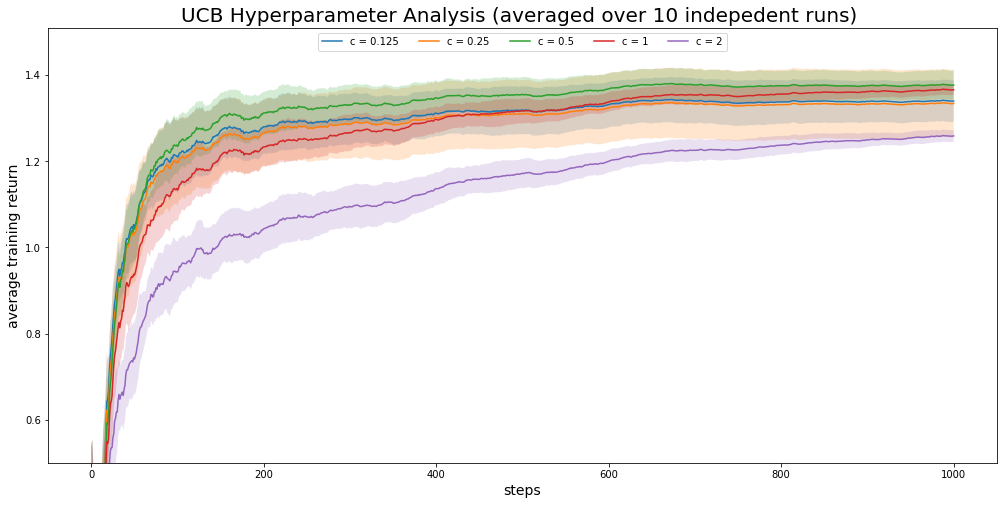

time: 757 ms


In [13]:
c=[0.125,0.25,0.5,1,2]
x=np.linspace(0, 1000, 1000)
plt.figure(figsize=(17,8))

for i in range(len(c)):

  train_mean, train_var,regret_mean, regret_var,test_mean, test_var = UCB(c[i])
  plt.plot(x,train_mean,label='c = '+str(c[i]))
  plt.fill_between(x,train_mean-train_var/2, train_mean+train_var/2,alpha=0.2)
  
plt.ylim(bottom=0.5)
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=5)
plt.title(r'UCB Hyperparameter Analysis (averaged over 10 indepedent runs) ', fontsize=20)
plt.xlabel('steps',fontsize=14)
plt.ylabel('average training return',fontsize=14)
plt.show()

##Softmax
For the Softmax algorithm, we considered $\alpha$ values of 0.0625, 0.125, 0.25, 0.5 and 1. From the chart below we see that softmax with $\alpha$ = 0.125 has a higher average training return over 1000 steps than softmax with any other hyperparameter tested. softmax with $\alpha$ = 0.5 performed very well early on, however it did suffer from high variance across the 10 indepedent runs and eventually softmax with $\alpha$ = 0.125 outperformed it in terms of average training return. Therefore for the final analysis we will use softmax with $\alpha$ = 0.125

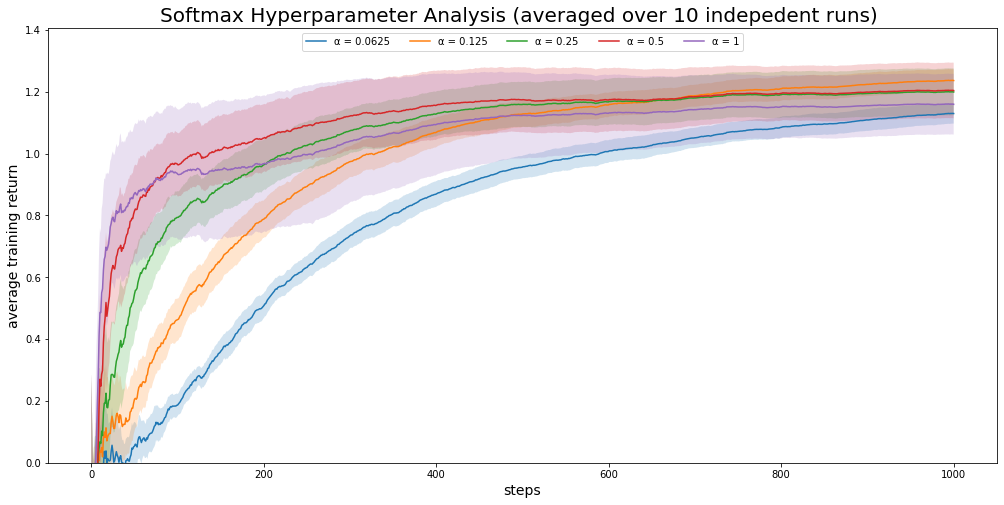

time: 850 ms


In [14]:
alpha=[1/16.0,0.125,0.25,0.5,1]

x=np.linspace(0, 1000, 1000)

plt.figure(figsize=(17,8))

for i in range(len(alpha)):
  train_mean, train_var,regret_mean, regret_var,test_mean, test_var = softmax(alpha[i])
  plt.plot(x,train_mean,label='\u03B1 = '+str(alpha[i]))
  plt.fill_between(x,train_mean-train_var/2, train_mean+train_var/2,alpha=0.2)
  

plt.ylim(bottom=0.)
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=6)
plt.title(r'Softmax Hyperparameter Analysis (averaged over 10 indepedent runs) ', fontsize=20)
plt.xlabel('steps',fontsize=14)
plt.ylabel('average training return',fontsize=14)
plt.show()

##Thompson Sampling
For the thompson sampling algorithm, we considered intial $\sigma_{init}$ values of 1, 10, 100, 1000 and 10000. This initial $\sigma_{init}$ value refered to the standard deviation of our prior distribution used in Thompson Sampling. From the chart below we see that thompson sampling with $\sigma_{init}$ = 1 has a higher average training return over 1000 steps than thompson sampling with any other hyperparameter tested. Surprisingly thompson sampling was relativly invariant to this hyperparameter value, I would guess that this is becuause our prior distribution had mean 0 and all the arms true values were relativly close to 0.  For the final analysis we will use thompson sampling with $\sigma_{init}$ = 1.

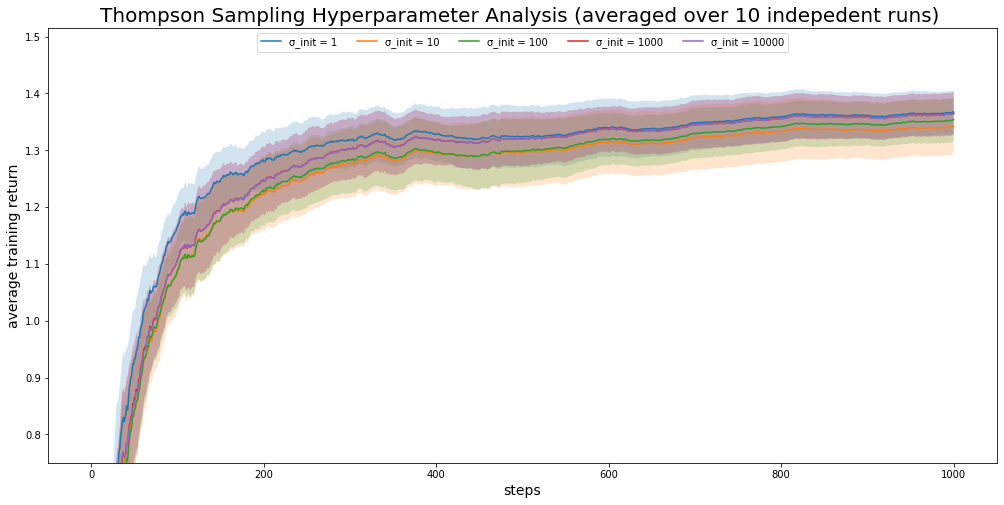

time: 908 ms


In [15]:
var_init=[1,10,100,1000,10000]
x=np.linspace(0, 1000, 1000)
plt.figure(figsize=(17,8))

for i in range(len(var_init)):
  train_mean, train_var,regret_mean, regret_var,test_mean, test_var = TSampling(var_init[i])
  plt.plot(x,train_mean,label='\u03C3_init = '+str(var_init[i]))
  plt.fill_between(x,train_mean-train_var/2, train_mean+train_var/2,alpha=0.2)
  
plt.ylim(bottom=0.75) 
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=5)
plt.title(r'Thompson Sampling Hyperparameter Analysis (averaged over 10 indepedent runs) ', fontsize=20)
plt.xlabel('steps',fontsize=14)
plt.ylabel('average training return',fontsize=14)
plt.show()

# Final Algorithm Evaluation
Below we compare the 3 algorithms with their choosen hyperparameters; UCB (c=0.5), Softmax ($\alpha$=0.125) and Thompson Sampling ($\sigma_{init}$ = 1)


In [16]:
#runs trials with choosen hyperparameters
training_average_reward = np.zeros((3,training_iterations))
regret = np.zeros((3,training_iterations))
test_reward = np.zeros((3,testing_iterations))

train_mean = np.zeros((3,training_iterations))
train_var = np.zeros((3,training_iterations))
regret_mean = np.zeros((3,training_iterations))
regret_var = np.zeros((3,training_iterations))
test_mean = np.zeros((3,testing_iterations))
test_var = np.zeros((3,testing_iterations))


train_mean[0:], train_var[0:],regret_mean[0:], regret_var[0:],test_mean[0:], test_var[0:] = UCB(0.5)
train_mean[1:], train_var[1:],regret_mean[1:], regret_var[1:],test_mean[1:], test_var[1:] = softmax(0.125)
train_mean[2:], train_var[2:],regret_mean[2:], regret_var[2:],test_mean[2:], test_var[2:] = TSampling(1)

time: 249 ms


#Average Training Return
Clearly UCB and Thompson sampling were the superior bandit algorithms in this case. Softmax did not improve as quickly and in 1000 steps was not able to catch up to UCB and Thompson sampling in terms of average training return, given more steps softmax could begin to catch up to the other two methods. UCB and Thompson Sampling both improved very quickly, with UCB improving slightly faster. At the end of 1000 steps UCB had an average training return just above Thompson sampling's. UCB also appears to have slightly lower variance across the 10 indepedent runs.

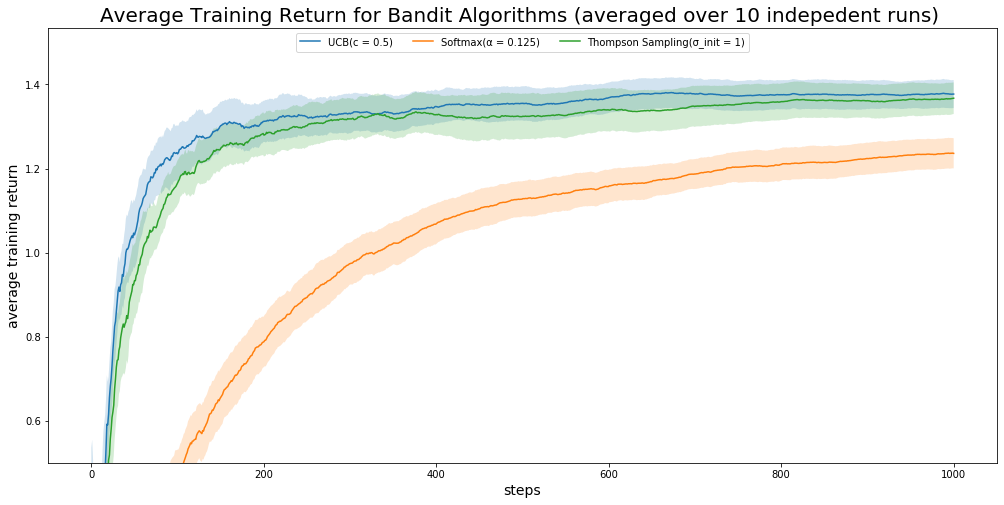

time: 363 ms


In [17]:
x=np.linspace(0, 1000, 1000)
plt.figure(figsize=(17,8))

labels = ['UCB(c = 0.5)','Softmax(\u03B1 = 0.125)','Thompson Sampling(\u03C3_init = 1)']

for i in range(3):
  plt.plot(x,train_mean[i,:],label=labels[i])
  plt.fill_between(x,train_mean[i,:]-train_var[i,:]/2, train_mean[i,:]+train_var[i,:]/2,alpha=0.2)

plt.ylim(bottom=0.5)
plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=3)
plt.title(r'Average Training Return for Bandit Algorithms (averaged over 10 indepedent runs) ', fontsize=20)
plt.xlabel('steps',fontsize=14)
plt.ylabel('average training return',fontsize=14)
plt.show()

#Regret Per Step
The regret per step plot below further explains the results from the average training return. UCB trained very quickly and by step 100 was almost always exploiting, and pulling the best arm ($q^*$= 1.435) therefore having no regret for most of the steps. Thompson sampling also trained very quickly but it appears that from steps 100 to 500 at least one run of thompson sampling was exploiting and pulling the second best arm ($q^*$= 1.219), therefore recieiving regret of roughly 0.2 per pull and raising the regret of thompson sampling averaged over 10 runs. Beyond step 100 it appears that both UCB and Thompson sampling explore very little. Softmax has far greater regret, across 1000 steps. Softmax did not find a good arm to exploit as quickly. Softmax explores far more than the other 2 algorithms, especially after step 500 where UCB and Thomspon sampling barely explore.

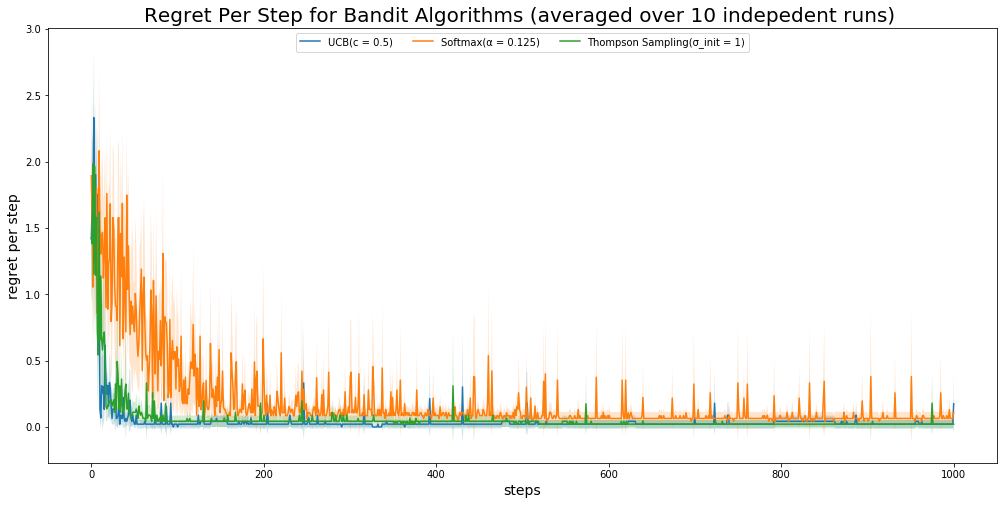

time: 420 ms


In [18]:
x=np.linspace(0, 1000, 1000)
plt.figure(figsize=(17,8))

labels = ['UCB(c = 0.5)','Softmax(\u03B1 = 0.125)','Thompson Sampling(\u03C3_init = 1)']

for i in range(3):
  plt.plot(x,regret_mean[i,:],label=labels[i])
  plt.fill_between(x,regret_mean[i,:]-regret_var[i,:]/2, regret_mean[i,:]+regret_var[i,:]/2,alpha=0.2)

plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=3)
plt.title(r'Regret Per Step for Bandit Algorithms (averaged over 10 indepedent runs) ', fontsize=20)
plt.xlabel('steps',fontsize=14)
plt.ylabel('regret per step',fontsize=14)
plt.show()

#Reward of Policy (Testing)
For this metric we trained each bandit algorithm for 10 iterations, then greedily took the best arm, pulled 5 times and averaged, to create our reward of policy data point. These were then averaged over 10 indepedent runs like all other figures.

Although very noisy this graph is quite interesting. Our first observation is that at the first testing instance softmax and thompson sampling significantly outperformed UCB. This is because UCB ensures that all actions are tested once before using its formula to explore or exploit, where as softmax and thompson sampling do not have that same requirement and can therefore exploit good actions before the first 10 iterations are complete. What is most interesting about this is that all three algorithms appear to be earning similar rewards at testing, even softmax. Although softmax explores a lot more and therefore has lower average training return and greater regret per step, when we greedily select its best action it appears to be as strong as UCB and Thompson sampling at evaluating the bandit arms. This is a great example of why doing training and testing plots is crucial, for an algorithm such as softmax it explores much more than the other two algorithms and therefore has weaker training performance, however its estimate of the best arm is near equal to that of UCB and thomspon sampling and therefore at testing performs very similarly.



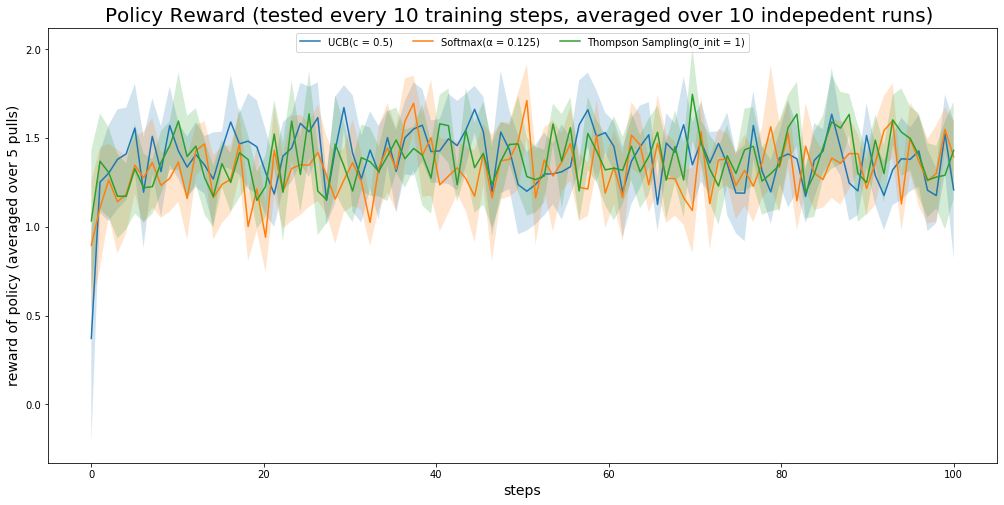

time: 433 ms


In [19]:
x=np.linspace(0, 100, 100)
plt.figure(figsize=(17,8))

labels = ['UCB(c = 0.5)','Softmax(\u03B1 = 0.125)','Thompson Sampling(\u03C3_init = 1)']

for i in range(3):
  plt.plot(x,test_mean[i,:],label=labels[i])
  plt.fill_between(x,test_mean[i,:]-test_var[i,:]/2, test_mean[i,:]+test_var[i,:]/2,alpha=0.2)

plt.legend(bbox_to_anchor=(0.5, 1), loc='upper center', ncol=3)
plt.title(r'Policy Reward (tested every 10 training steps, averaged over 10 indepedent runs) ', fontsize=20)
plt.xlabel('steps',fontsize=14)
plt.ylabel('reward of policy (averaged over 5 pulls)',fontsize=14)
plt.show()